The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install flax
!pip install d2l==1.0.0-beta0


# Gated Recurrent Units (GRU)
:label:`sec_gru`


As RNNs and particularly the LSTM architecture (:numref:`sec_lstm`)
rapidly gained popularity during the 2010s,
a number of researchers began to experiment 
with simplified architectures in hopes 
of retaining the key idea of incorporating
an internal state and multiplicative gating mechanisms
but with the aim of speeding up computation.
The gated recurrent unit (GRU) :cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014` 
offered a streamlined version of the LSTM memory cell
that often achieves comparable performance
but with the advantage of being faster 
to compute :cite:`Chung.Gulcehre.Cho.ea.2014`.


In [1]:
import jax
from flax import linen as nn
from jax import numpy as jnp
from d2l import jax as d2l

## Reset Gate and Update Gate

Here, the LSTM's three gates are replaced by two:
the *reset gate* and the *update gate*.
As with LSTMs, these gates are given sigmoid activations,
forcing their values to lie in the interval $(0, 1)$.
Intuitively, the reset gate controls how much of the previous state 
we might still want to remember.
Likewise, an update gate would allow us to control 
how much of the new state is just a copy of the old one.
:numref:`fig_gru_1` illustrates the inputs for both
the reset and update gates in a GRU, 
given the input of the current time step
and the hidden state of the previous time step.
The outputs of the gates are given 
by two fully connected layers
with a sigmoid activation function.

![Computing the reset gate and the update gate in a GRU model.](../img/gru-1.svg)
:label:`fig_gru_1`

Mathematically, for a given time step $t$,
suppose that the input is a minibatch
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
(number of examples $=n$; number of inputs $=d$)
and the hidden state of the previous time step 
is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ 
(number of hidden units $=h$). 
Then the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ 
and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xr}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hr}} + \mathbf{b}_\textrm{r}),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xz}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hz}} + \mathbf{b}_\textrm{z}),
\end{aligned}
$$

where $\mathbf{W}_{\textrm{xr}}, \mathbf{W}_{\textrm{xz}} \in \mathbb{R}^{d \times h}$ 
and $\mathbf{W}_{\textrm{hr}}, \mathbf{W}_{\textrm{hz}} \in \mathbb{R}^{h \times h}$ 
are weight parameters and $\mathbf{b}_\textrm{r}, \mathbf{b}_\textrm{z} \in \mathbb{R}^{1 \times h}$ 
are bias parameters.


## Candidate Hidden State

Next, we integrate the reset gate $\mathbf{R}_t$ 
with the regular updating mechanism
in :eqref:`rnn_h_with_state`,
leading to the following
*candidate hidden state*
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\textrm{hh}} + \mathbf{b}_\textrm{h}),$$
:eqlabel:`gru_tilde_H`

where $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$
are weight parameters,
$\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$
is the bias,
and the symbol $\odot$ is the Hadamard (elementwise) product operator.
Here we use a tanh activation function.

The result is a *candidate*, since we still need 
to incorporate the action of the update gate.
Comparing with :eqref:`rnn_h_with_state`,
the influence of the previous states
can now be reduced with the
elementwise multiplication of
$\mathbf{R}_t$ and $\mathbf{H}_{t-1}$
in :eqref:`gru_tilde_H`.
Whenever the entries in the reset gate $\mathbf{R}_t$ are close to 1, 
we recover a vanilla RNN such as that in :eqref:`rnn_h_with_state`.
For all entries of the reset gate $\mathbf{R}_t$ that are close to 0, 
the candidate hidden state is the result of an MLP with $\mathbf{X}_t$ as input. 
Any pre-existing hidden state is thus *reset* to defaults.

:numref:`fig_gru_2` illustrates the computational flow after applying the reset gate.

![Computing the candidate hidden state in a GRU model.](../img/gru-2.svg)
:label:`fig_gru_2`


## Hidden State

Finally, we need to incorporate the effect of the update gate $\mathbf{Z}_t$.
This determines the extent to which the new hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ 
matches the old state $\mathbf{H}_{t-1}$ compared with how much 
it resembles the new candidate state $\tilde{\mathbf{H}}_t$.
The update gate $\mathbf{Z}_t$ can be used for this purpose, 
simply by taking elementwise convex combinations 
of $\mathbf{H}_{t-1}$ and $\tilde{\mathbf{H}}_t$.
This leads to the final update equation for the GRU:

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$


Whenever the update gate $\mathbf{Z}_t$ is close to 1,
we simply retain the old state. 
In this case the information from $\mathbf{X}_t$ is ignored, 
effectively skipping time step $t$ in the dependency chain. 
By contrast, whenever $\mathbf{Z}_t$ is close to 0,
the new latent state $\mathbf{H}_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$. 
:numref:`fig_gru_3` shows the computational flow after the update gate is in action.

![Computing the hidden state in a GRU model.](../img/gru-3.svg)
:label:`fig_gru_3`


In summary, GRUs have the following two distinguishing features:

* Reset gates help capture short-term dependencies in sequences.
* Update gates help capture long-term dependencies in sequences.

## Implementation from Scratch

To gain a better understanding of the GRU model, let's implement it from scratch.

### (**Initializing Model Parameters**)

The first step is to initialize the model parameters.
We draw the weights from a Gaussian distribution
with standard deviation to be `sigma` and set the bias to 0. 
The hyperparameter `num_hiddens` defines the number of hidden units.
We instantiate all weights and biases relating to the update gate, 
the reset gate, and the candidate hidden state.


In [2]:
class GRUScratch(d2l.Module):
    num_inputs: int
    num_hiddens: int
    sigma: float = 0.01

    def setup(self):
        init_weight = lambda name, shape: self.param(name,
                                                     nn.initializers.normal(self.sigma),
                                                     shape)
        triple = lambda name : (
            init_weight(f'W_x{name}', (self.num_inputs, self.num_hiddens)),
            init_weight(f'W_h{name}', (self.num_hiddens, self.num_hiddens)),
            self.param(f'b_{name}', nn.initializers.zeros, (self.num_hiddens)))

        self.W_xz, self.W_hz, self.b_z = triple('z')  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple('r')  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple('h')  # Candidate hidden state

### Defining the Model

Now we are ready to [**define the GRU forward computation**].
Its structure is the same as that of the basic RNN cell, 
except that the update equations are more complex.


In [3]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    # Use lax.scan primitive instead of looping over the
    # inputs, since scan saves time in jit compilation
    def scan_fn(H, X):
        Z = jax.nn.sigmoid(jnp.matmul(X, self.W_xz) + jnp.matmul(H, self.W_hz) +
                        self.b_z)
        R = jax.nn.sigmoid(jnp.matmul(X, self.W_xr) +
                        jnp.matmul(H, self.W_hr) + self.b_r)
        H_tilde = jnp.tanh(jnp.matmul(X, self.W_xh) +
                           jnp.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        return H, H  # return carry, y

    if H is None:
        batch_size = inputs.shape[1]
        carry = jnp.zeros((batch_size, self.num_hiddens))
    else:
        carry = H

    # scan takes the scan_fn, initial carry state, xs with leading axis to be scanned
    carry, outputs = jax.lax.scan(scan_fn, carry, inputs)
    return outputs, carry

### Training

[**Training**] a language model on *The Time Machine* dataset
works in exactly the same manner as in :numref:`sec_rnn-scratch`.


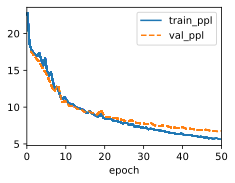

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## [**Concise Implementation**]

In high-level APIs, we can directly instantiate a GRU model.
This encapsulates all the configuration detail that we made explicit above.


In [5]:
class GRU(d2l.RNN):
    num_hiddens: int

    @nn.compact
    def __call__(self, inputs, H=None, training=False):
        if H is None:
            batch_size = inputs.shape[1]
            H = nn.GRUCell.initialize_carry(jax.random.PRNGKey(0),
                                            (batch_size,), self.num_hiddens)

        GRU = nn.scan(nn.GRUCell, variable_broadcast="params",
                      in_axes=0, out_axes=0, split_rngs={"params": False})

        H, outputs = GRU()(H, inputs)
        return outputs, H

The code is significantly faster in training as it uses compiled operators 
rather than Python.


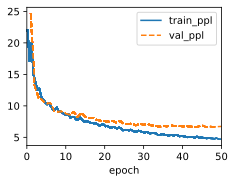

In [6]:
gru = GRU(num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

After training, we print out the perplexity on the training set
and the predicted sequence following the provided prefix.


In [7]:
model.predict('it has', 20, data.vocab, trainer.state.params)

'it has and the prect and h'

## Summary

Compared with LSTMs, GRUs achieve similar performance but tend to be lighter computationally.
Generally, compared with simple RNNs, gated RNNS, just like LSTMs and GRUs,
can better capture dependencies for sequences with large time step distances.
GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. 
They can also skip subsequences by turning on the update gate.


## Exercises

1. Assume that we only want to use the input at time step $t'$ to predict the output at time step $t > t'$. What are the best values for the reset and update gates for each time step?
1. Adjust the hyperparameters and analyze their influence on running time, perplexity, and the output sequence.
1. Compare runtime, perplexity, and the output strings for `rnn.RNN` and `rnn.GRU` implementations with each other.
1. What happens if you implement only parts of a GRU, e.g., with only a reset gate or only an update gate?


[Discussions](https://discuss.d2l.ai/t/18017)
